In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

from src.emotion.analysis.feature_generator import FeatureGenerator, VADGenerator

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
emotions = ["Angry", "Disgust", "Happy", "Sad", "Surprise", "Fear", "Neutral"]
vad = ["Valence", "Arousal", "Dominance"]

In [3]:
folder = '/home/moritz/Workspace/masterthesis/data/identities/'
df = pd.read_csv(folder + 'team_20/2023-01-10/team_20_2023-01-10.csv')

In [4]:
features_pipeline = [VADGenerator()]

feature_generator = FeatureGenerator(features_pipeline)
feature_df = feature_generator.generate_features(df)

feature_df.head()

,Frame,ClassID,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,GazeDetections,Brightness,Valence,Arousal,Dominance
0,0,person_id3,0.805271,417.100403,603.412964,0.001298,0.983145,0.007416,0.005371,0.000224,0.000135,0.002410,[],140.276564,-0.982533,0.003702,-0.979937
1,0,person_id1,0.799670,1092.678223,632.916748,0.002967,0.017306,0.320276,0.019811,0.203477,0.009455,0.426707,[],140.276564,0.270736,0.516364,0.276670
2,0,person_id4,0.715621,838.627258,258.571106,0.008836,0.234053,0.020929,0.008893,0.142328,0.002063,0.582898,[],140.276564,-0.232915,0.165263,-0.215244
3,5,person_id3,0.807259,417.817810,603.769714,0.001241,0.953628,0.022795,0.016446,0.000363,0.000268,0.005258,[],140.308587,-0.948789,0.008221,-0.946307
4,5,person_id1,0.804896,1092.973022,633.406616,0.003357,0.026146,0.469920,0.021953,0.121223,0.011890,0.345511,[],140.308587,0.406575,0.584437,0.413288


In [5]:
preprocessing_pipeline = [
    LinearInterpolator(),
    RollingAverageSmoother(
        window_size=150,
        cols=[*emotions, *vad],
    ),
]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(feature_df)

pre_df.head()

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,Valence,Arousal,Dominance,ClassID
0,0,0.799670,1092.678223,632.916748,0.003045,0.015704,0.323409,0.017264,0.132065,0.010008,0.498506,140.276564,0.277389,0.451262,0.283478,person_id1
1,1,0.800715,1092.737183,633.014722,0.003060,0.015585,0.327032,0.017164,0.131138,0.010046,0.495975,140.282968,0.281177,0.454113,0.287298,person_id1
2,2,0.801760,1092.796143,633.112695,0.003072,0.015462,0.330293,0.017055,0.130294,0.010071,0.493755,140.289373,0.284633,0.456675,0.290778,person_id1
3,3,0.802805,1092.855103,633.210669,0.003081,0.015333,0.333204,0.016937,0.129529,0.010083,0.491833,140.295777,0.287770,0.458960,0.293932,person_id1
4,4,0.803851,1092.914062,633.308643,0.003086,0.015201,0.335780,0.016811,0.128841,0.010082,0.490200,140.302182,0.290600,0.460978,0.296772,person_id1


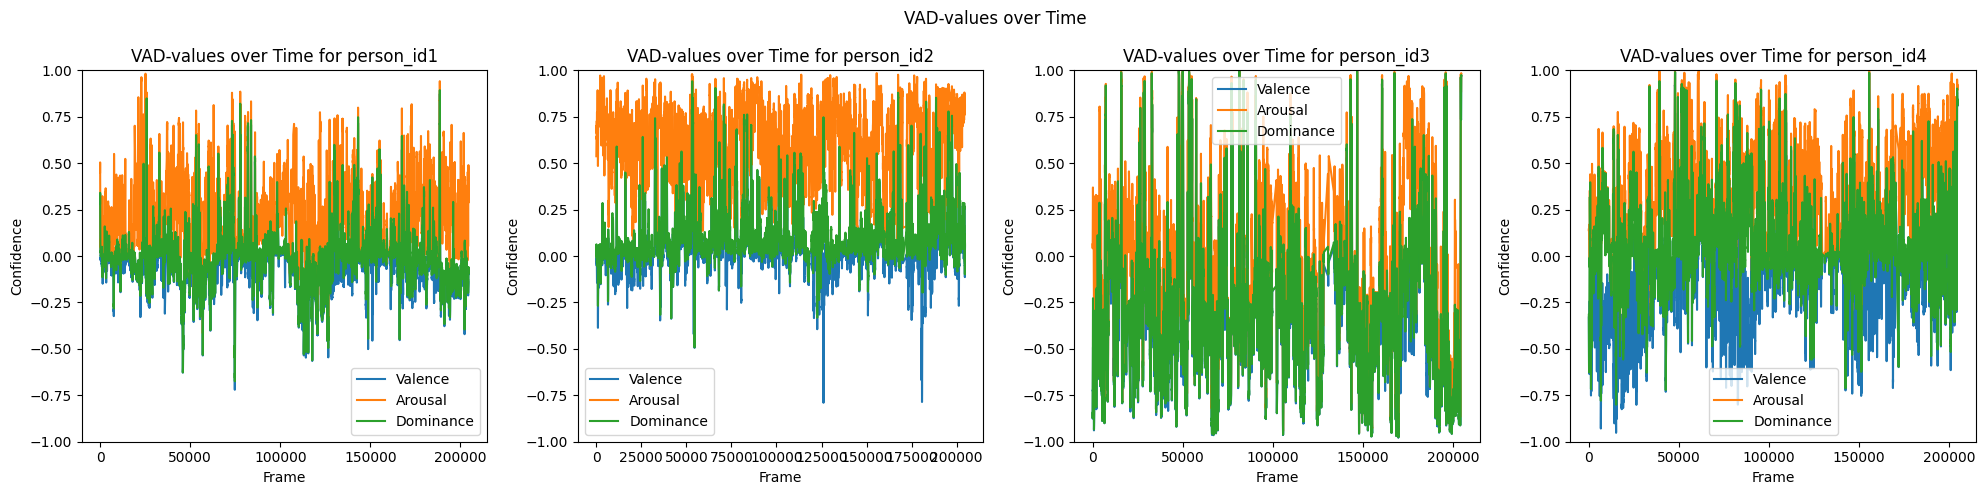

In [6]:
grouped = pre_df.groupby("ClassID")

fig = plt.figure(figsize=(20, 5), tight_layout=True)
fig.suptitle("VAD-values over Time")

for i, (person_id, group) in enumerate(grouped):
    emotions_rolling = group[["Frame", *vad]]

    ax = fig.add_subplot(1, 4, i + 1)
    emotions_rolling.plot(
        x="Frame",
        y=vad,
        ax=ax,
    )

    ax.set_title(f"VAD-values over Time for {person_id}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("Confidence")
    ax.set_ylim(-1, 1)

plt.show()

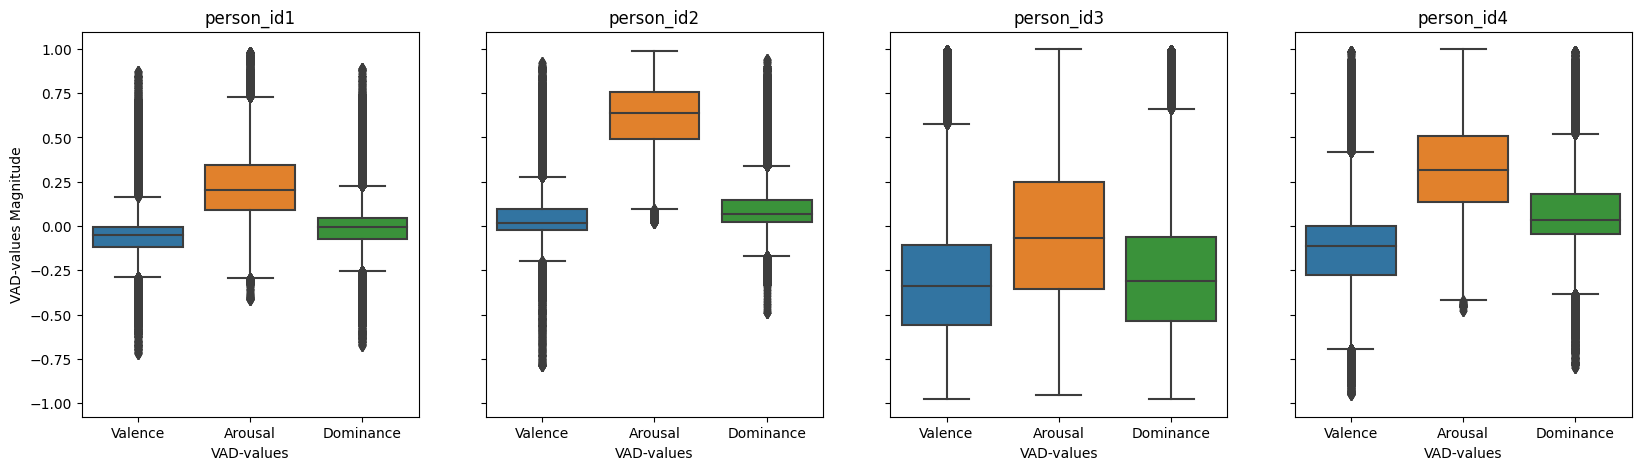

In [7]:
# Set the figure size
fig, axes = plt.subplots(1, len(pre_df['ClassID'].unique()), figsize=(20, 5), sharey=True)

# Loop over each ClassID and plot a boxplot for each emotion
for i, cid in enumerate(pre_df['ClassID'].unique()):
    # Subset the data for the current ClassID
    subset = pre_df[pre_df['ClassID'] == cid][vad]
    # Plot the boxplot for each emotion on a separate subplot
    sns.boxplot(data=subset, ax=axes[i])
    axes[i].set_title(f'{cid}')
    axes[i].set_xlabel('VAD-values')

# Set the y-axis label on the first subplot only
axes[0].set_ylabel('VAD-values Magnitude')

# Show the plot
plt.show()

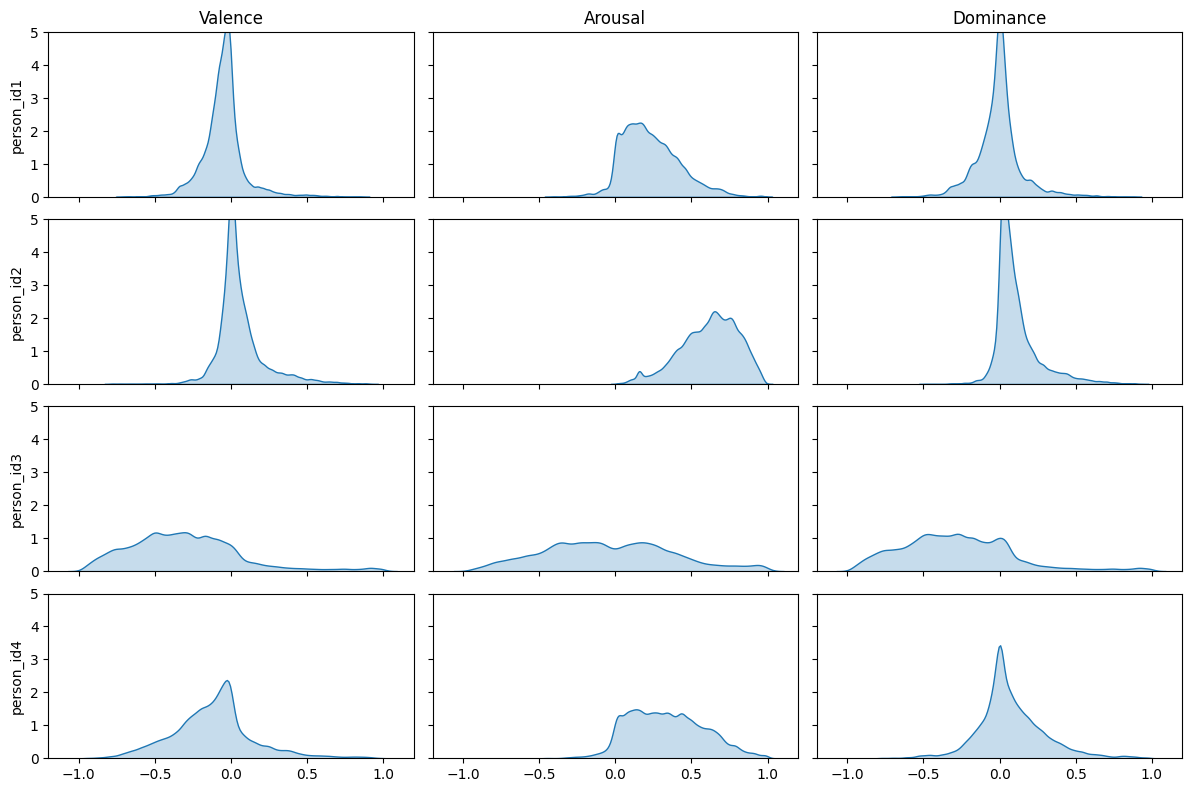

In [8]:
# Group the data by ClassID and emotion columns
grouped = pre_df.groupby(['ClassID', *vad]).size().reset_index(name='count')

# Define the size of the figure and the number of rows and columns
fig, axes = plt.subplots(nrows=len(grouped['ClassID'].unique()), ncols=len(vad), figsize=(12, 8), sharex=True, sharey=True)

# Set the x and y axis limits
xlim = (-1.2, 1.2)
ylim = (0, 5)

# Loop over each ClassID and emotion, and plot a distribution plot
for i, cid in enumerate(grouped['ClassID'].unique()):
    for j, e in enumerate(vad):
        sns.kdeplot(data=grouped[(grouped['ClassID'] == cid)], x=e, ax=axes[i, j], fill=True)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel(f'{cid}')
        if i == 0:
            axes[i, j].set_title(f'{e}')
        axes[i, j].set_xlim(xlim)
        axes[i, j].set_ylim(ylim)

# Adjust the spacing between subplots
fig.tight_layout(pad=1)
plt.show()